core           INFO 	Loading data for Italian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 3 completed the race distance 00:00.086000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '77', '16', '11', '55', '18', '14', '63', '31', '6', '5',

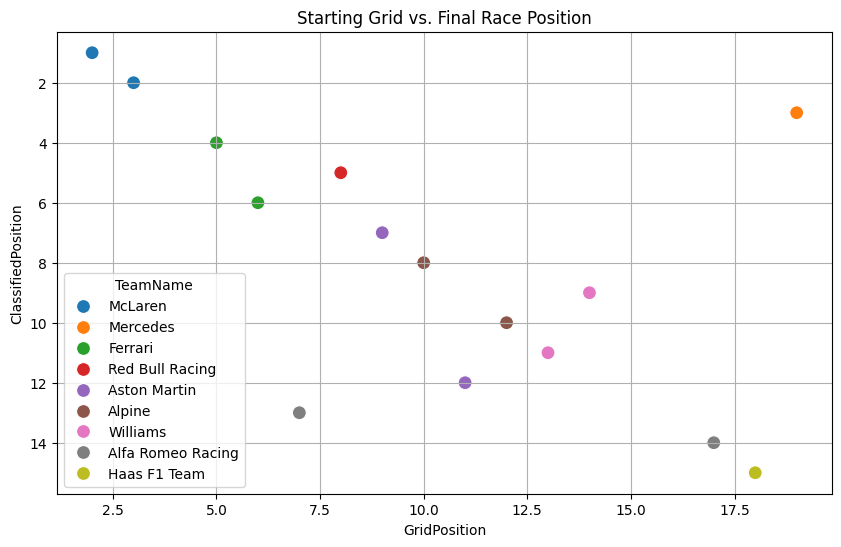

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import fastf1
import pandas as pd

session = fastf1.get_session(2021, 'Monza', 'R')

# Get the results from your session
session.load()
results = session.results

# 1. Select only the columns we need to simplify the data
plot_df = results[['GridPosition', 'ClassifiedPosition', 'TeamName']].copy()

# 2. Convert to numeric, turning errors (like strings) into NaN
plot_df['GridPosition'] = pd.to_numeric(plot_df['GridPosition'], errors='coerce')
plot_df['ClassifiedPosition'] = pd.to_numeric(plot_df['ClassifiedPosition'], errors='coerce')

# 3. Drop rows that have NaN in Grid or Position (like DNFs or non-starts)
plot_df = plot_df.dropna(subset=['GridPosition', 'ClassifiedPosition'])

# 4. Now Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='GridPosition', y='ClassifiedPosition', hue='TeamName', s=100)
plt.title('Starting Grid vs. Final Race Position')
plt.gca().invert_yaxis() 
plt.grid(True)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/fastf1/plotting/_plotting.py:57: FutureWarning: The `misc_mpl_mods` argument was dropped from `.setup_mpl()` in version 3.6.0 and has no effect anymore. It will be removed in a future version of FastF1.
  warnings.warn(
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req 

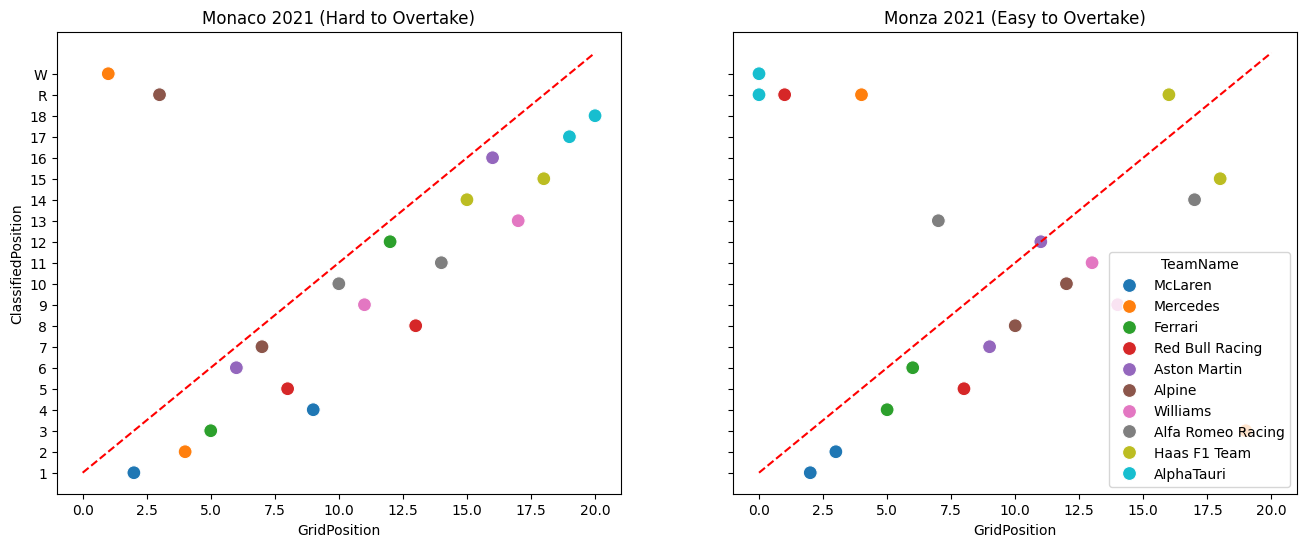

In [17]:
import fastf1
import fastf1.plotting
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Setup
fastf1.Cache.enable_cache('f1_cache')
fastf1.plotting.setup_mpl(misc_mpl_mods=False) # Makes charts look "F1 style"

# 2. Load the two different worlds
# Notice we use 'R' for Race, and the NAMES instead of numbers to be safe
monaco = fastf1.get_session(2021, 'Monaco', 'R')
monza = fastf1.get_session(2021, 'Monza', 'R')

monaco.load()
monza.load()

# 3. Create a side-by-side plot
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot Monaco (The "Procession")
sns.scatterplot(data=monaco.results, x='GridPosition', y='ClassifiedPosition', 
                hue='TeamName', ax=ax[0], s=100, legend=False)
ax[0].set_title("Monaco 2021 (Hard to Overtake)")
ax[0].plot([0, 20], [0, 20], 'r--') # Reference line

# Plot Monza (The "Temple of Speed")
sns.scatterplot(data=monza.results, x='GridPosition', y='ClassifiedPosition', 
                hue='TeamName', ax=ax[1], s=100)
ax[1].set_title("Monza 2021 (Easy to Overtake)")
ax[1].plot([0, 20], [0, 20], 'r--') # Reference line

ax[0].invert_yaxis() # Flip so P1 is at the top
plt.show()

In [18]:
import pandas as pd
import fastf1

fastf1.Cache.enable_cache('f1_cache') 

def get_full_season_data(year):
    all_races = []
    
    # Get the schedule for the 2025 season
    schedule = fastf1.get_event_schedule(year)
    
    # Filter for official races only (exclude testing)
    # We also check if the race has actually happened yet (EventDate < Today)
    # But since it's 2026, we know all 2025 races are done.
    race_schedule = schedule[schedule['EventFormat'] != 'testing']
    
    print(f"📥 Downloading data for {year} season...")
    
    for i, row in race_schedule.iterrows():
        race_name = row['EventName']
        round_num = row['RoundNumber']
        
        try:
            # Load the race session
            session = fastf1.get_session(year, round_num, 'R')
            session.load(telemetry=False, weather=False, messages=False)
            
            # Get the results
            results = session.results
            
            # Add identification columns
            results['Round'] = round_num
            results['RaceName'] = race_name
            results['Year'] = year
            
            # Keep key columns (including Status for crash analysis)
            columns_to_keep = ['Driver', 'TeamName', 'GridPosition', 'ClassifiedPosition', 
                               'Points', 'Status', 'Round', 'RaceName']
            
            # Check if columns exist before selecting (prevents errors if data is empty)
            available_cols = [c for c in columns_to_keep if c in results.columns]
            race_data = results[available_cols]
            
            all_races.append(race_data)
            print(f"✅ Loaded Round {round_num}: {race_name}")
            
        except Exception as e:
            print(f"⚠️ Skipped Round {round_num} ({race_name}): {e}")
            
    # Combine everything
    if all_races:
        season_df = pd.concat(all_races, ignore_index=True)
        return season_df
    else:
        return pd.DataFrame() # Return empty if nothing found

# 1. Run for 2025
f1_data_2025 = get_full_season_data(2025)

# 2. Inspect the data
print(f"\n🎉 Collection Complete! Total Rows: {len(f1_data_2025)}")
print(f1_data_2025.head())

# 3. SAVE TO CSV (Crucial Step!)
# This creates a file in your project folder you can open in Excel
f1_data_2025.to_csv('f1_2025_season_data.csv', index=False)
print("💾 Data saved to 'f1_2025_season_data.csv'")

core           INFO 	Loading data for Australian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '87'
core        WARNING 	Fixed incorrect tyre stint information for driver '30'


📥 Downloading data for 2025 season...


core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 1: Australian Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['81', '4', '63', '1', '31', '12', '23', '87', '18', '55', '6', '30', '7', '5', '27', '22', '14', '16', '44', '10']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 2: Chinese Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '63', '12', '44', '6', '23', '87', '14', '22', '10', '55', '7', '27', '30', '31', '5', '18']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 3: Japanese Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['81', '63', '4', '16', '44', '1', '10', '31', '22', '87', '12', '23', '6', '7', '14', '30', '18', '5', '55', '27']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 4: Bahrain Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['81', '1', '16', '4', '63', '12', '44', '55', '23', '6', '14', '30', '87', '31', '27', '18', '7', '5', '22', '10']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core        WARNING 	Fixed incorrect tyre stint information for driver '31'
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driv

✅ Loaded Round 5: Saudi Arabian Grand Prix


core        WARNING 	Driver 81 completed the race distance 00:00.036000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '63', '1', '23', '12', '16', '44', '55', '22', '6', '31', '10', '27', '14', '18', '30', '5', '87', '7']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 6: Miami Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '44', '23', '16', '63', '55', '6', '22', '14', '27', '10', '30', '18', '43', '87', '5', '12', '31']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 7: Emilia Romagna Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['4', '16', '81', '1', '44', '6', '31', '30', '23', '55', '63', '87', '43', '5', '18', '27', '22', '12', '14', '10']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 8: Monaco Grand Prix


core           INFO 	Finished loading data for 19 drivers: ['81', '4', '16', '63', '27', '44', '6', '10', '14', '1', '30', '5', '22', '55', '43', '31', '87', '12', '23']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 9: Spanish Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['63', '1', '12', '81', '16', '44', '14', '27', '31', '55', '87', '22', '43', '5', '10', '6', '18', '4', '30', '23']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 10: Canadian Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['4', '81', '16', '44', '63', '30', '14', '5', '27', '31', '87', '6', '10', '18', '43', '22', '23', '1', '12', '55']
core           INFO 	Loading data for British Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 11: Austrian Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['4', '81', '27', '44', '1', '10', '18', '23', '14', '63', '87', '55', '31', '16', '22', '12', '6', '5', '30', '43']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '81'
core        WARNING 	Fixed incorrect tyre stint information for driver '4'
core        WARNING 	Fixed incorrect tyre stint information for driver '16'
core        WARNING 	Fixed incorrect tyre stint information for d

✅ Loaded Round 12: British Grand Prix


core        WARNING 	Fixed incorrect tyre stint information for driver '43'
core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '16', '1', '63', '23', '44', '30', '5', '10', '87', '27', '22', '18', '31', '12', '14', '55', '43', '6']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 13: Belgian Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['4', '81', '63', '16', '14', '5', '18', '30', '1', '12', '6', '44', '27', '55', '23', '31', '22', '43', '10', '87']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 14: Hungarian Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['81', '1', '6', '63', '23', '87', '18', '14', '22', '31', '43', '30', '55', '27', '5', '12', '10', '4', '16', '44']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 15: Dutch Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '63', '44', '23', '5', '12', '6', '55', '87', '22', '30', '31', '10', '43', '18', '14', '27']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 16: Italian Grand Prix


core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '55', '12', '30', '22', '4', '44', '16', '6', '5', '87', '23', '31', '14', '27', '18', '10', '43', '81']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 17: Azerbaijan Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['63', '1', '4', '81', '12', '16', '14', '44', '87', '55', '6', '22', '18', '23', '30', '43', '5', '31', '10', '27']
core           INFO 	Loading data for United States Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 18: Singapore Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['1', '4', '16', '44', '81', '63', '22', '27', '87', '14', '30', '18', '12', '23', '31', '6', '43', '5', '10', '55']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 19: United States Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['4', '16', '1', '87', '81', '12', '63', '44', '31', '5', '22', '23', '6', '18', '10', '43', '55', '14', '27', '30']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 20: Mexico City Grand Prix


core        WARNING 	Driver 4 completed the race distance 00:00.010000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['4', '12', '1', '63', '81', '87', '30', '6', '27', '10', '23', '31', '55', '14', '43', '18', '22', '44', '16', '5']
core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '63'


✅ Loaded Round 21: São Paulo Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['1', '63', '12', '16', '55', '6', '27', '44', '31', '87', '14', '22', '10', '30', '43', '23', '5', '18', '4', '81']
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 22: Las Vegas Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['1', '81', '55', '4', '12', '63', '14', '16', '30', '22', '23', '44', '5', '43', '31', '10', '18', '6', '87', '27']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Loaded Round 23: Qatar Grand Prix


core           INFO 	Finished loading data for 20 drivers: ['1', '81', '4', '16', '63', '14', '31', '44', '27', '18', '5', '87', '55', '22', '12', '23', '6', '30', '10', '43']


✅ Loaded Round 24: Abu Dhabi Grand Prix

🎉 Collection Complete! Total Rows: 479
          TeamName  GridPosition ClassifiedPosition  Points    Status  Round  \
0          McLaren           1.0                  1    25.0  Finished      1   
1  Red Bull Racing           3.0                  2    18.0  Finished      1   
2         Mercedes           4.0                  3    15.0  Finished      1   
3         Mercedes          16.0                  4    12.0  Finished      1   
4         Williams           6.0                  5    10.0  Finished      1   

                RaceName  
0  Australian Grand Prix  
1  Australian Grand Prix  
2  Australian Grand Prix  
3  Australian Grand Prix  
4  Australian Grand Prix  
💾 Data saved to 'f1_2025_season_data.csv'


In [19]:
import pandas as pd

# (Assuming you already ran the 'get_corrected_data' function from the previous step)
# If you need to reload the raw data, uncomment the next line:
# df_raw = get_corrected_data(2025) 

print(f"✅ Raw Data Loaded. Shape: {df_raw.shape}")

# --- STEP 1: CLEANING ---
# Clean Target (Position)
df_raw['ClassifiedPosition'] = pd.to_numeric(df_raw['ClassifiedPosition'], errors='coerce').fillna(20)
df_raw['IsPodium'] = df_raw['ClassifiedPosition'].apply(lambda x: 1 if x <= 3 else 0)

# Clean Input (Grid)
df_raw['GridPosition'] = df_raw['GridPosition'].replace(0, 20)

# --- STEP 2: ENCODING ---
# This creates the True/False columns for Teams and Drivers
df_encoded = pd.get_dummies(df_raw, columns=['TeamName', 'Driver'], prefix=['Team', 'Driver'])

# --- THE FIX IS HERE ---
# Instead of forcing the WHOLE table to int, we only find the Boolean (True/False) columns
bool_cols = df_encoded.select_dtypes(include=['bool']).columns

# Convert ONLY those columns to 1 and 0
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

# --- STEP 3: FINAL POLISH ---
# We can drop 'Status' now because we have 'IsPodium' and 'ClassifiedPosition'
# We keep 'RaceName' so you can read the CSV, but we'll drop it before Machine Learning
df_final = df_encoded.drop(columns=['Status'])

print("\nSample of New Columns:")
print(df_final.filter(like='Driver_').columns[:5])

# Save it
df_final.to_csv('final_f1_dataset.csv', index=False)
print("\n💾 Saved corrected data to 'final_f1_dataset.csv'")

✅ Raw Data Loaded. Shape: (479, 6)

Sample of New Columns:
Index(['Driver_ALB', 'Driver_ALO', 'Driver_ANT', 'Driver_BEA', 'Driver_BOR'], dtype='object')

💾 Saved corrected data to 'final_f1_dataset.csv'


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Load your final cleaned data
df = pd.read_csv('final_f1_dataset.csv')

# 2. SEPARATE FEATURES (X) AND TARGET (y)
# X = The questions (Grid Position, Team, Driver)
# y = The answer (Did they get a Podium?)

# CRITICAL: Drop 'ClassifiedPosition' because that reveals the answer!
# Also drop 'RaceName' because it's text that the model can't read.
X = df.drop(columns=['IsPodium', 'ClassifiedPosition'])
y = df['IsPodium']

# 3. SPLIT THE DATA
# test_size=0.2 means 20% of races are saved for the "Exam"
# random_state=42 ensures we get the same shuffle every time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. TRAIN THE MODEL
# n_estimators=100 means we create 100 "Decision Trees" that vote on the result
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. TAKE THE EXAM
y_pred = model.predict(X_test)

# 6. GRADE THE MODEL
accuracy = accuracy_score(y_test, y_pred)
print(f"🎓 Model Accuracy: {accuracy:.2%}")

print("\n📊 Detailed Report:")
print(classification_report(y_test, y_pred))

print("\nmatrix Confusion Matrix (The Truth Table):")
print(confusion_matrix(y_test, y_pred))

🎓 Model Accuracy: 90.62%

📊 Detailed Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        80
           1       0.82      0.56      0.67        16

    accuracy                           0.91        96
   macro avg       0.87      0.77      0.81        96
weighted avg       0.90      0.91      0.90        96


matrix Confusion Matrix (The Truth Table):
[[78  2]
 [ 7  9]]


/var/folders/k8/c32kl0_x56b224y182fxm9_r0000gn/T/ipykernel_24951/3902794571.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_df, x='Importance', y='Feature', palette='viridis')


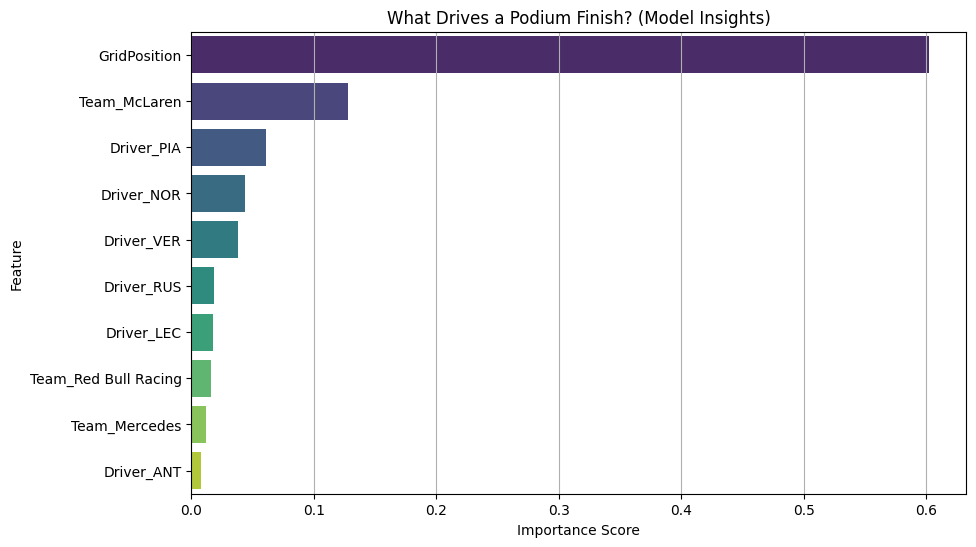

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get importance scores from the model
importances = model.feature_importances_

# 2. Get the names of the columns (features)
feature_names = X.columns

# 3. Create a DataFrame to organize them
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 4. Sort by importance so the big bars are at the top
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(10)

# 5. Plot!
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_df, x='Importance', y='Feature', palette='viridis')
plt.title('What Drives a Podium Finish? (Model Insights)')
plt.xlabel('Importance Score')
plt.grid(axis='x')
plt.show()

In [24]:
import pandas as pd

def predict_podium(grid_pos, team_name, driver_code):
    # 1. Create a blank template matching our model's inputs
    input_data = pd.DataFrame(0, index=[0], columns=X.columns)
    
    # 2. Set the Grid Position
    input_data['GridPosition'] = grid_pos
    
    # 3. Set the Team (One-Hot Encoding)
    # We construct the column name (e.g., 'Team_McLaren') and set it to 1
    team_col = f"Team_{team_name}"
    if team_col in input_data.columns:
        input_data[team_col] = 1
    
    # 4. Set the Driver (One-Hot Encoding)
    driver_col = f"Driver_{driver_code}"
    if driver_col in input_data.columns:
        input_data[driver_col] = 1
        
    # 5. Ask the Model for the Probability
    # returns [Probability of Failure, Probability of Success]
    prob = model.predict_proba(input_data)[0][1]
    
    print(f"🏎️  {driver_code} | {team_name} | Start: P{grid_pos}")
    print(f"📊 Podium Chance: {prob:.1%}")
    print("-" * 30)

# --- SCENARIO 1: The "Ideal" Lando ---
# Lando Norris in McLaren starting Pole Position (P1)
predict_podium(1, 'McLaren', 'NOR')

# --- SCENARIO 2: The "Recovery Drive" ---
# Lando Norris in McLaren starting Mid-Pack (P10)
predict_podium(10, 'McLaren', 'NOR')

# --- SCENARIO 3: The "Rival" Benchmark ---
# Max Verstappen in Red Bull starting P5
predict_podium(5, 'Red Bull Racing', 'VER')

🏎️  NOR | McLaren | Start: P1
📊 Podium Chance: 63.2%
------------------------------
🏎️  NOR | McLaren | Start: P10
📊 Podium Chance: 6.0%
------------------------------
🏎️  VER | Red Bull Racing | Start: P5
📊 Podium Chance: 59.5%
------------------------------


In [25]:
import joblib

# 1. Create a dictionary to save EVERYTHING we need
# We save the model AND the column names (so we remember the order of inputs later)
model_bundle = {
    'model': model,
    'model_columns': X.columns.tolist()
}

# 2. Save (Dump) it to a file
joblib.dump(model_bundle, 'f1_podium_model.pkl')

print("✅ Model frozen and saved to 'f1_podium_model.pkl'")

✅ Model frozen and saved to 'f1_podium_model.pkl'


In [27]:
import pandas as pd
import fastf1

# --- STEP 1: RELOAD RAW DATA ---
# We use the same function as before to get the original columns back
# Ensure cache is enabled so this is instant
fastf1.Cache.enable_cache('f1_cache') 

def get_data_with_race_names(year):
    all_races = []
    schedule = fastf1.get_event_schedule(year)
    # Filter for completed races only
    race_schedule = schedule[schedule['EventFormat'] != 'testing']
    
    print(f"🔄 Re-assembling {year} data (reading from cache)...")
    
    for i, row in race_schedule.iterrows():
        try:
            session = fastf1.get_session(year, row['RoundNumber'], 'R')
            session.load(telemetry=False, weather=False, messages=False)
            results = session.results
            
            # KEY FIX: We explicitly ask for 'RaceName' here
            results['RaceName'] = row['EventName']
            
            # Select columns we need
            cols = ['RaceName', 'Abbreviation', 'TeamName', 'GridPosition', 'ClassifiedPosition', 'Status']
            race_data = results[cols].copy()
            race_data = race_data.rename(columns={'Abbreviation': 'Driver'})
            
            all_races.append(race_data)
        except Exception as e:
            print(f"Skipping Round {row['RoundNumber']}: {e}")
            
    return pd.concat(all_races, ignore_index=True)

# Load the fresh data
df_v2 = get_data_with_race_names(2025)

# --- STEP 2: APPLY CIRCUIT MAPPING ---
circuit_map = {
    'Bahrain Grand Prix': 'Traditional',
    'Saudi Arabian Grand Prix': 'Street',
    'Australian Grand Prix': 'Street',
    'Japanese Grand Prix': 'Traditional',
    'Chinese Grand Prix': 'Traditional',
    'Miami Grand Prix': 'Street',
    'Emilia Romagna Grand Prix': 'Traditional',
    'Monaco Grand Prix': 'Street',
    'Canadian Grand Prix': 'Street',
    'Spanish Grand Prix': 'Traditional',
    'Austrian Grand Prix': 'High Speed',
    'British Grand Prix': 'High Speed',
    'Hungarian Grand Prix': 'Traditional',
    'Belgian Grand Prix': 'High Speed',
    'Dutch Grand Prix': 'Traditional',
    'Italian Grand Prix': 'High Speed',
    'Azerbaijan Grand Prix': 'Street',
    'Singapore Grand Prix': 'Street',
    'United States Grand Prix': 'Traditional',
    'Mexico City Grand Prix': 'Traditional',
    'São Paulo Grand Prix': 'Traditional',
    'Las Vegas Grand Prix': 'Street',
    'Qatar Grand Prix': 'Traditional',
    'Abu Dhabi Grand Prix': 'Traditional'
}

df_v2['CircuitType'] = df_v2['RaceName'].map(circuit_map).fillna('Traditional')
print(f"✅ Added Circuit Types: {df_v2['CircuitType'].unique()}")

# --- STEP 3: CLEANING ---
df_v2['ClassifiedPosition'] = pd.to_numeric(df_v2['ClassifiedPosition'], errors='coerce').fillna(20)
df_v2['IsPodium'] = df_v2['ClassifiedPosition'].apply(lambda x: 1 if x <= 3 else 0)
df_v2['GridPosition'] = df_v2['GridPosition'].replace(0, 20)

# --- STEP 4: ENCODING ---
# Now we include 'CircuitType' in the encoding list
df_final_v2 = pd.get_dummies(df_v2, columns=['TeamName', 'Driver', 'CircuitType'], 
                             prefix=['Team', 'Driver', 'Circuit'])

# Convert bools to ints
bool_cols = df_final_v2.select_dtypes(include=['bool']).columns
df_final_v2[bool_cols] = df_final_v2[bool_cols].astype(int)

# --- STEP 5: TRAIN MODEL V2 ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Drop non-numeric columns
X = df_final_v2.drop(columns=['IsPodium', 'ClassifiedPosition', 'RaceName', 'Status'])
y = df_final_v2['IsPodium']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_v2 = RandomForestClassifier(n_estimators=100, random_state=42)
model_v2.fit(X_train, y_train)

print(f"\n🎓 Model V2 Accuracy: {accuracy_score(y_test, model_v2.predict(X_test)):.2%}")

core           INFO 	Loading data for Australian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


🔄 Re-assembling 2025 data (reading from cache)...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '87'
core        WARNING 	Fixed incorrect tyre stint information for driver '30'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req       

✅ Added Circuit Types: ['Street' 'Traditional' 'High Speed']

🎓 Model V2 Accuracy: 90.62%
